The option value at S = 100 is 10.42794


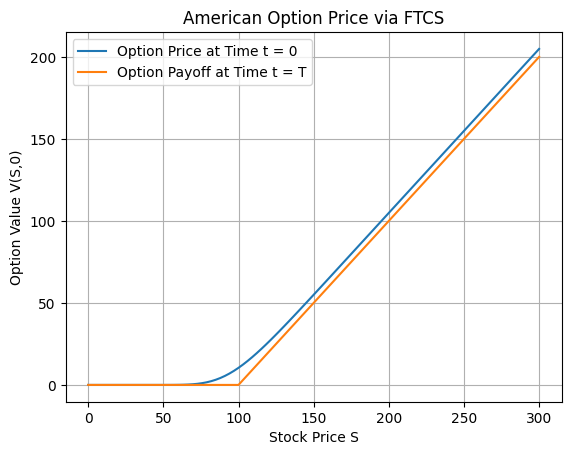

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#### Option and Market Parameters
r = 0.05 #risk-free rate of interest
K = 100 #strike price
S_0 = 100 #current price of the underlying
sig = 0.2 #volatility (standard deviation of returns on underlying asset)
T = 1 #expiry
d = 0.0 #dividend rate (assumes continuous dividends)
q = 1 #option type parameter (q = 1 for call and q = -1 for put)

#### Grid Parameters
S_min = 0 #mininum stock price
S_max = 3*K #maximum stock price (numerical feature introducint an artificial boundary; needs to approximate far field S -> +\infty)
NS = 100 #number of asset price grid points
dS = (S_max - S_min)/(NS - 1)
Nt = 8000 #number of time steps (number of time grid points will be Nt+1)
dt = T/Nt

#### Ensure stability
lam = 0.5 * sig**2 * S_max**2 * dt/dS**2
if lam > 0.5:
    print('Warning: The FTCS scheme may be unstable with the given parameters. dt will be reduced to ensure stability.')
    dt = 0.9 * dS**2 / (sig**2 * S_max**2)
    Nt = int(T/dt) + 1

#### Generate the grid
S = np.linspace(S_min, S_max, NS)
t = np.linspace(0,T,Nt+1)

#### Initialize Option Value Function V, Impose Terminal Condition and Impose Boundary Conditions at Time t = T
#### Note: In this setup, time zero corresponds to the terminal time t = T. Think of time to expiry tau = T - t.
V = np.zeros((Nt+1,NS))
V[0,:] = np.maximum(q * (S - K),0) #Initial condition: payoff function at t = T

## Boundary Conditions
if q == 1: #Call option
    V[0,0] = 0 #BC at S = 0 imposed at time t = T (V(0,T) = 0)
    V[0,-1] = 2 * V[0,-2] - V[0,-3] #Far-field BC at time t = T (zero Gamma)
else: #Put option
    V[0,0] = K #BC at S = 0 imposed at time t = T (V(0,T) = K)
    V[0,-1] = 0 #Far-field BC at t = T (put is worthless at expiry for S >> K)

#### Timestepping via FTCS Finite Difference Scheme
for n in range(Nt):
    for j in range(1,NS-1):
        Delta = (V[n,j+1] - V[n,j-1])/(2 * dS) #Use central difference to approximate Delta at time t = t_n
        Gamma = (V[n,j+1] - 2 * V[n,j] + V[n,j-1])/(dS**2) #Use central difference to approximate Gamma at time t = t_n

        ## Compute Coefficients
        diffusion = -0.5 * sig**2 * S[j]**2
        advection = -(r - d) * S[j]
        discount = r

        ## Update Interior V (Allowing for Early Exercise)
        V[n+1,j] = np.maximum(V[n,j] - dt * (diffusion * Gamma + advection * Delta + discount * V[n,j]), q * ( S[j] - K ) )

        ## Enforce BCs
        if q == 1:
            V[n+1,0] = 0
            V[n+1,-1] = 2 * V[n+1,-2] - V[n+1,-3]
        else:
            V[n+1,0] = K * np.exp(-r * (T - t[n+1]))
            V[n+1,-1] = 0

#### Interpolate to Price the Option for S = S_0
V_0 = np.interp(S_0, S, V[-1,:])
print(f'The option value at S = {S_0} is {V_0:.5f}')

#### Visualize the Value Function
plt.plot(S, V[-1,:], label="Option Price at Time t = 0")
plt.plot(S, np.maximum(q * (S - K),0), label="Option Payoff at Time t = T")
#plt.axvline(K, linestyle="--", color="r", label="Strike Price")
plt.xlabel('Stock Price S')
plt.ylabel('Option Value V(S,0)')
plt.title('American Option Price via FTCS')
plt.legend()
plt.grid()
plt.show()
